In [6]:
# Import libraries
import numpy as np
import pandas as pd
import argparse

import matplotlib.pyplot as plt
import os
from scipy.special import softmax
from kmembert.models import HealthBERT
from kmembert.utils import create_session
import json

In [7]:
# Import argparse
parser = argparse.ArgumentParser()
parser.add_argument("-d", "--data_folder", type=str, default="data/ehr/test.csv", 
    help="data path to access to the testing file")
parser.add_argument("-p", "--path_dataset", type=str, default="data/ehr/test.csv", 
    help="data path to access to the testing file")
parser.add_argument("-r", "--resume", type=str, default="kmembert-base", 
    help="result folder in with the saved checkpoint will be reused")

parser.add_argument("-nr", "--nrows", type=int, default=1, 
    help="maximum number of samples for testing")
parser.add_argument("-f", "--folder_to_save", type=str, default="graphs", 
    help="folder to save the figures")
args = parser.parse_args("")

In [8]:
# Fonctions used to plot
def extract_attention(sentence):
    inputs = model.tokenizer.encode(sentence, return_tensors='pt')
    outputs = model.camembert(inputs, output_attentions=True)
    attention = outputs[-1]
    tokens = model.tokenizer.convert_ids_to_tokens(inputs[0])
    attention = np.array([l.detach().numpy() for l in attention])
    return tokens, attention


def compute_attention(sentence):
    tokens, attention = extract_attention(sentence)
    evolution_from_tokens = np.zeros((12, len(tokens)))
    for i in range(12):
        att = attention[i][0]
        evolution_from_tokens[i] = att.mean(1).mean(0)   
        if i ==11:
          to_cls = att[:, :, 0].mean(0)
    return softmax(evolution_from_tokens[:, 1:], axis = -1), softmax(to_cls[1:], axis = -1),  tokens[1:-1]

In [9]:
global model
_, _, device, config = create_session(args)
#config = Config(args)
# config.path_result = ""
# config.resume = "training_21-04-05_10h02m00s"

# Load the model
model = HealthBERT(device, config)

# Load the text that we are going to use for attention-based interpretation
file_to_classify = pd.read_csv(config.data_folder, nrows = config.nrows)
texts_to_classify = file_to_classify.Texte.values

> DEVICE:  cpu
> ROOT:    c:\Users\DIPIAZZA\Documents\CLBProjet\VirtualMachine_T2\KmemBERT
> SESSION: c:\Users\DIPIAZZA\Documents\CLBProjet\VirtualMachine_T2\KmemBERT\results\ipykernel_launcher_22-05-31_13h50m47s

Using mode density (Health BERT checkpoint kmembert-base)

Loading camembert and its tokenizer...
if config.resume from health_bert.py
Resuming with model at kmembert-base...
Successfully loaded



> DEVICE:  cpu
> ROOT:    c:\Users\DIPIAZZA\Documents\CLBProjet\VirtualMachine_T2\KmemBERT
> SESSION: c:\Users\DIPIAZZA\Documents\CLBProjet\VirtualMachine_T2\KmemBERT\results\ipykernel_launcher_22-05-31_13h51m23s

Using mode density (Health BERT checkpoint kmembert-base)

Loading camembert and its tokenizer...
if config.resume from health_bert.py
Resuming with model at kmembert-base...
Successfully loaded

 Sont présents : P. CASSIER ; C. TERRET ; M. BRAHMI ; A. VINCENEUX ; C. KOMURKIEWICZ ; L. MOLINA ; S. LAURENT.  Carcinome épidermoïde du pouce en évolution axillaire primo-traitée par chimiothérapie puis par CEMIPLIMAB, patient éventuellement incluable dans l'étude ISI-JX. A voir en consultation dans ce sens
ci
nome
▁du
▁en
axillaire
▁pri
mo
▁par
chimio
▁par
able
▁l
▁en
▁ce
▁sens


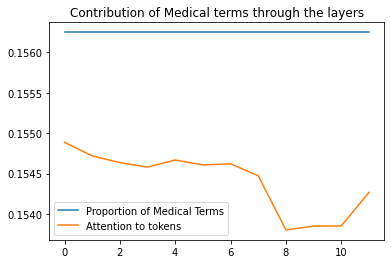

In [11]:
global model
_, _, device, config = create_session(args)
#config = Config(args)
# config.path_result = ""
# config.resume = "training_21-04-05_10h02m00s"

# Load the model
model = HealthBERT(device, config)

# Load the text that we are going to use for attention-based interpretation
file_to_classify = pd.read_csv(config.data_folder, nrows = config.nrows)
texts_to_classify = file_to_classify.Texte.values


print(texts_to_classify[0])

# Load medical vocabulary. Can be ignored if we don't want to focus on it.
f = open("medical_voc/large.json")
dictio = json.load(f)
med_voc = []
for i in range(len(dictio)):
    med_voc.append(dictio[i][0])

input = model.tokenizer.encode(' '.join(med_voc), return_tensors='pt')
medical_vocab = model.tokenizer.convert_ids_to_tokens(input[0])
medical_vocab.remove('<s>')
medical_vocab.remove('</s>')

# Follow Attention From Medical terms through the layers

attention_evolution = []
percentage_med_terms = []
for sentence in texts_to_classify:
    attention_layers, to_cls_attention, sentence_tokenized = compute_attention(sentence)
    idx_med = []
    for i in range(len(sentence_tokenized)):
        if (len(sentence_tokenized[i]) > 1) and sentence_tokenized[i] in medical_vocab: # 3 can be changed to include more words
            print(sentence_tokenized[i])
            idx_med.append(i)
    percentage_med_terms.append(len(idx_med)/len(sentence_tokenized))
    evolutions = attention_layers[:, idx_med].sum(axis = 1)
    attention_evolution.append(evolutions)

final_evolution = np.array(attention_evolution).mean(axis = 0)
percentage_medical_terms = [np.mean(percentage_med_terms)]*len(final_evolution)
plt.figure()
plt.plot(percentage_medical_terms, label = 'Proportion of Medical Terms')
plt.plot(final_evolution, label = 'Attention to tokens')
plt.legend()
plt.title("Contribution of Medical terms through the layers")
plt.savefig('graphs/Attention_medical_terms.png')
    

# If we want the token attributions, we can take the mean of the attention to the other tokens from a token along all the layers:
# We can also directly take the attention to the CLS coming from each token

token_attributes = []
token_attributes_cls = []
for sentence in texts_to_classify:
    token_attributes_dict = {}
    token_attributes_cls_dict = {}
    attention_layers, to_cls_attention, sentence_tokenized = compute_attention(sentence)
    attentions = attention_layers.mean(axis = 0)
    for i in range(len(sentence_tokenized)):
        token_attributes_dict[sentence_tokenized[i]] = attentions[i]
        token_attributes_cls_dict[sentence_tokenized[i]] = to_cls_attention[i]

    token_attributes.append(token_attributes_dict)
    token_attributes_cls.append(token_attributes_cls_dict)

    show_n = 10
    final_dict = dict(sorted(token_attributes_dict.items(), key=lambda item: abs(item[1]))[:show_n])
    # Plot the results for the word attributes (green for positive contribution and red for negative contribution)
    x = list(final_dict.keys())
    y = list(final_dict.values())
    colors = ['green']*show_n 

    plt.figure()
    plt.barh(x, y, color=colors)
    plt.title(f'Word Attributions far a selected EHR using attention')
    plt.savefig(f'graphs/interpretation/attention_based.png')    
    plt.close()
    
    # Plot the attribution of words using their attention to the [CLS] token at the final layer
    final_dict = dict(sorted(token_attributes_cls_dict.items(), key=lambda item: abs(item[1]))[:show_n])
    # Plot the results for the word attributes (green for positive contribution and red for negative contribution)
    x = list(final_dict.keys())
    y = list(final_dict.values())
    colors = ['green']*show_n 

    plt.figure()
    plt.barh(x, y, color=colors)
    plt.title(f'Word Attributions far a selected EHR using attention')
    plt.savefig(f'graphs/interpretation/attention_cls_based.png')    
    plt.close()